In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
import RK4_numba as RK4

In [5]:
import numba 
print(tf.version.VERSION)
print(numba.__version__)

1.14.0
0.48.0


In [3]:
r = RK4.Rocket()

dAngle = 0.01*np.pi
dThrottle = 0.05
dt = 0.1

#R = []
#RX = []
#RY = []
#V = []
#Fuel = []

def step(r, action):
    pt_vars = np.array([r.rx, r.ry, r.vx, r.vy, r.fuelm], dtype=np.float32)
    
    angle, throttle, staged = r.input_vars
    
    if action == 0:
        angle += dAngle
        throttle += dThrottle
    elif action == 1:
        angle -= dAngle
        throttle += dThrottle
    elif action == 2:
        angle += dAngle
        throttle -= dThrottle
    elif action == 3:
        angle -= dAngle
        throttle -= dThrottle
    elif action == 4:
        angle = angle
        throttle = throttle
    else:
        print("NO ACTION SELECTED")
        
    if throttle > 1:
        throttle = 1
    elif throttle < 0:
        throttle = 0

    
    #OUT OF FUEL
    if r.fuelm <= 0:
        print("Out Of Fuel")
        done = True
    #CRASHES
    elif np.sqrt(r.rx**2+r.ry**2) < r.sea:
        print("Crashed")
        done = True
    #TIME CUTOFF
    elif r.t > 100000:
        print("Time Limit")
        done = True
    #ACHIEVE ORBIT HERE DON"T FORGET TO INCLUDE THIS HERE 
    else:
        done = False
        
    r.input_vars = np.array([angle, throttle, staged], dtype=np.float32)
    r.RK4_step(pt_vars, dt, r.input_vars)
    
    return r, done

'''
actions = {
(+throttle, +angle),
(+throttle, -angle),
(-throttle, +angle),
(-throttle, -angle),
(do nothing)
}
'''

def reward_1(state):
    rx, ry, vx, vy, m, has_staged = state[0]
    
    x = np.sqrt(rx**2+ry**2)
    v = np.sqrt(vx**2+vy**2)
    
    rw_x = 1/(1+np.exp(-0.00004*(x-r.karman)))
    rw_v = 1/(1+np.exp(-0.001*(v-7790/2)))
    rw_m = 0  #0.1*m/r.mi
    
    punish = 0
    if np.sqrt(r.rx**2+r.ry**2) < r.sea:
        punish = -2
    
    return rw_x + rw_v + rw_m + punish

def reward_2(state):
    rx, ry, vx, vy, m, has_staged = state[0]
    
    x = np.sqrt(rx**2+ry**2)
    
    rw_x = np.exp(-1*(x-r.sea-200000)**2/(2*40000**2))
    punish = -np.exp(-1*(x-r.sea)**2/(2*4000**2))
    
    return rw_x + punish

def reward_3(state):
    rx, ry, vx, vy, m, has_staged = state[0]
    
    x = np.sqrt(rx**2+ry**2)
    
    rw_x = np.exp(-1*(x-r.sea-200000)**2/(5*40000**2))
    
    return rw_x

In [4]:
inputs = keras.Input(shape=(6))
x = keras.layers.Dense(16, activation="relu")(inputs)
x = keras.layers.Dense(32, activation="relu")(x)
outputs = keras.layers.Dense(5, activation=None)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
def train(model, replay_memory):
    batch = np.random.choice(replay_memory, 32, replace=True)
    
    s_p = np.array(list(map(lambda x: x['s_p'], batch)))
    s = np.array(list(map(lambda x: x['s'], batch)))
    
    q_s_p = model.predict(s_p)
    targets = model.predict(s)
    
    for i,m in enumerate(batch): 
        a = m['a']
        r = m['r']
        done = m['done']
        if not done:  target = r + discount_factor * np.max(q_s_p)
        else:         target = r
        targets[i][a] = target

    h = model.fit(s, targets, epochs=1, verbose=0)
    return model

In [6]:
epochs = 20
greed = 1
greed_decay = 0.99
discount_factor = 0.8

replay_memory = []
max_mem_size = 80000

all_RX = []
all_RY = []
all_rewards =[]

for i in range(epochs):
    print("EPOCH: ", i)
    r = RK4.Rocket()
    state = np.array([[r.rx, r.ry, r.vx, r.vy, r.m, int(r.has_staged)]])
    greed *= greed_decay
    
    RX = []
    RY = []
    rewards = []

    done = False
    while not done:
        if np.random.random() < greed:
            action = np.random.randint(0, 5)
        else:
            action = np.argmax(model.predict(state))
            
        RX.append(r.rx)
        RY.append(r.ry)
            
        r, done = step(r, action)
        new_state = np.array([[r.rx, r.ry, r.vx, r.vy, r.m, int(r.has_staged)]])
        reward = reward_3(state)
        rewards.append(reward)
        
        if len(replay_memory) > max_mem_size:
            replay_memory.pop(random.randrange(len(replay_memory)))
            
        replay_memory.append({'s': state[0], 'a': action, 'r': reward, "s_p": new_state[0], 'done': done})
        
        model = train(model, replay_memory)
        state = new_state
            
        
    all_rewards.append(sum(rewards))
    print('Reward: ', sum(rewards))
    if i % 1 == 0:
        all_RX.append(RX)
        all_RY.append(RY)
        

EPOCH:  0
Out Of Fuel
Reward:  653.921571375718
EPOCH:  1
Out Of Fuel
Reward:  239.21758917497715
EPOCH:  2
Out Of Fuel
Reward:  634.9097058845214
EPOCH:  3
Out Of Fuel
Reward:  662.8890133653913
EPOCH:  4
Crashed
Reward:  155.5006488424697
EPOCH:  5
Out Of Fuel
Reward:  170.2849133807048
EPOCH:  6
Out Of Fuel
Reward:  586.2448960751894
EPOCH:  7
Crashed
Reward:  13.544340111471467
EPOCH:  8
Crashed
Reward:  13.469651601974872
EPOCH:  9
Crashed
Reward:  73.52517943428188
EPOCH:  10
Crashed
Reward:  35.74580321920917
EPOCH:  11
Out Of Fuel
Reward:  628.5953580222238
EPOCH:  12
Crashed
Reward:  2.6697851775320993
EPOCH:  13
Crashed
Reward:  18.578299230755448
EPOCH:  14
Crashed
Reward:  18.531065683825364
EPOCH:  15
Crashed
Reward:  31.34085947695876
EPOCH:  16
Crashed
Reward:  32.398006161556104
EPOCH:  17
Crashed
Reward:  74.11128499916417
EPOCH:  18
Crashed
Reward:  4.654752784585904
EPOCH:  19
Crashed
Reward:  12.628950554726938


/Users/thomasdixon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


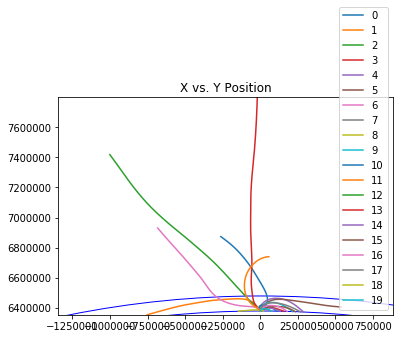

In [7]:
#NEED TO PLOT SOMETHING TO SHOW PROGRESS
all_RX = np.array(all_RX)
all_RY = np.array(all_RY)


rad = 6378000
surface = plt.Circle((0, 0), rad, color='b', fill=False)
karman_line = plt.Circle((0, 0), rad+100000, color='b', fill=False)
#karman = rad + 100000

ax = plt.gca()
for i in range(len(all_RX)):
    plt.plot(all_RX[i], all_RY[i], label=f"{i}")
    
ax.add_patch(surface)
ax.add_patch(karman_line)
plt.xlim(min([min(i) for i in all_RX]), max([max(i) for i in all_RX]))
plt.ylim(min([min(i) for i in all_RY]), max([max(i) for i in all_RY]))
plt.title("X vs. Y Position")
plt.axes().set_aspect('equal','datalim')
plt.legend()
plt.show()

In [6]:
plt.plot(all_rewards)
plt.ylabel("Rewards")
plt.xlabel("Epochs")

NameError: name 'all_rewards' is not defined

In [9]:
len(replay_memory)

41996

In [11]:
import pandas as pd
f = pd.DataFrame(replay_memory)